In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kartik.sonaghela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data.csv')
df.head()

,review,rating
0,It was nice produt. I like it's design a lot. It's easy to carry. And. Looked stylish.READ MORE,5
1,awesome sound....very pretty to see this nd the sound quality was too good I wish to take this product loved this product 😍😍😍READ MORE,5
2,"awesome sound quality. pros 7-8 hrs of battery life (including 45 mins approx call time)Awesome sound output. Bass and treble are really very clear without equaliser. With equaliser, sound wary de...",4
3,I think it is such a good product not only as per the quality but also the design is quite good . I m using this product from January ... In this pandamic situation it has became the most useful a...,5
4,awesome bass sound quality very good bettary long life and I have a purchase Rs.999 only really grateful product don't forget to likeREAD MORE,5


In [4]:
# function to plot most frequent terms
def freq_words(x, terms ):
    all_words = ' '.join([text for text in x])
    
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    # selecting top 30 most frequent words
    d = words_df.nlargest(columns="count", n = terms)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()


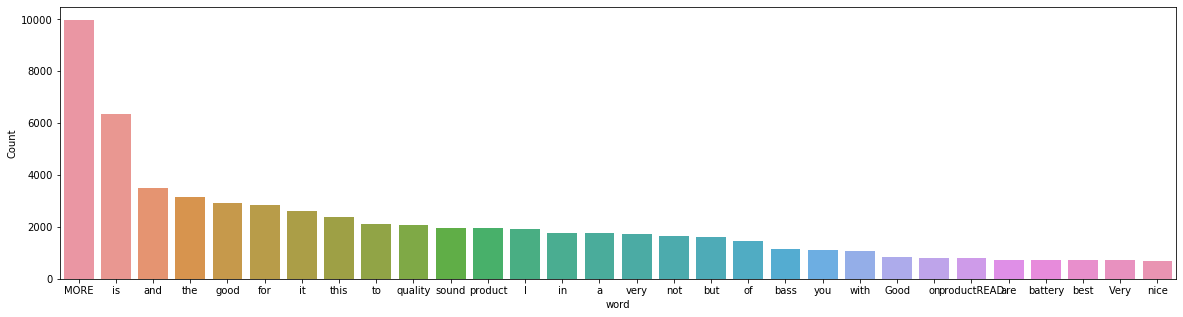

In [5]:
freq_words(df['review'],30)

In [6]:
# remove unwanted characters, numbers and symbols
df['review'] = df['review'].str.replace("[^a-zA-Z#]", " ")

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [8]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['review']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

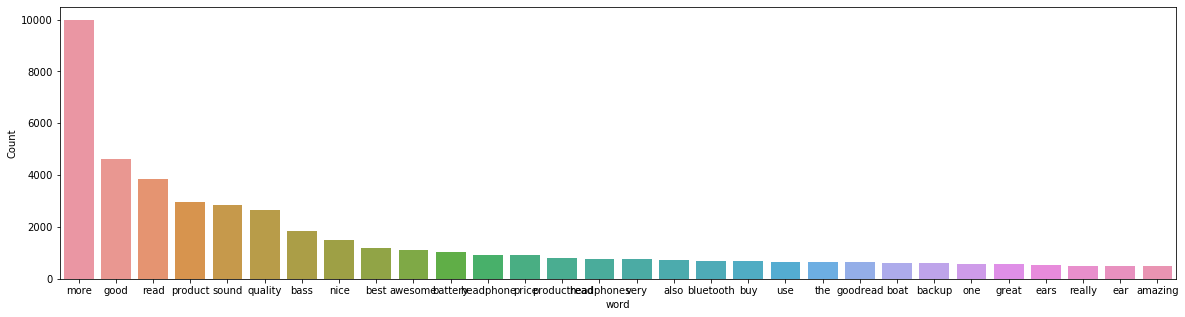

In [9]:
freq_words(reviews, 30)

In [10]:
df.head()

,review,rating
0,was nice produt like design lot easy carry And Looked stylish READ MORE,5
1,awesome sound very pretty see this the sound quality was too good wish take this product loved this product READ MORE,5
2,awesome sound quality pros hrs battery life including mins approx call time Awesome sound output Bass and treble are really very clear without equaliser With equaliser sound wary depends the hands...,4
3,think such good product not only per the quality but also the design quite good using this product from January this pandamic situation has became the most useful and helpful Overall the bass and ...,5
4,awesome bass sound quality very good bettary long life and have purchase only really grateful product don forget likeREAD MORE,5


In [11]:
!python -m spacy download en_core_web_sm 

2021-12-12 14:01:09.916452: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-12-12 14:01:09.916546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "C:\Users\kartik.sonaghela\Anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py", line 485, in wrap_socket
    cnx.do_handshake()
  File "C:\Users\kartik.sonaghela\Anaconda3\lib\site-packages\OpenSSL\SSL.py", line 1934, in do_handshake
    self._raise_ssl_error(self._ssl, result)
  File "C:\Users\kartik.sonaghela\Anaconda3\lib\site-packages\OpenSSL\SSL.py", line 1671, in _raise_ssl_error
    _raise_current_error()
  File "C:\Users\kartik.sonaghela\Anaconda3\lib\site-packages\OpenSSL\_util.py", line 54, in exception_from_error_queue
    raise exception_type(errors)
OpenSSL.SSL.Error: [('SSL routines', 'tls_proc

In [12]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [13]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['awesome', 'sound', 'pretty', 'see', 'sound', 'quality', 'good', 'wish', 'take', 'product', 'loved', 'product', 'read', 'more']


In [14]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['awesome', 'sound', 'sound', 'quality', 'good', 'wish', 'product', 'product']


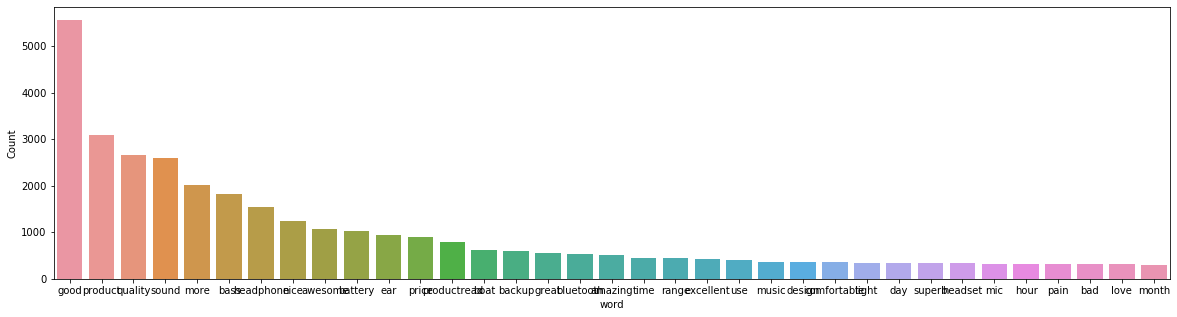

In [15]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))


df['review'] = reviews_3

freq_words(df['review'], 35)

In [16]:
dictionary = corpora.Dictionary(reviews_2)

In [17]:
print(dictionary)
print(len(dictionary))
print(dictionary[1])

Dictionary(4440 unique tokens: ['carry', 'design', 'easy', 'lot', 'nice']...)
4440
design


In [18]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [19]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [20]:
lda_model.print_topics()

[(0,
  '0.078*"headphone" + 0.058*"good" + 0.039*"boat" + 0.036*"bluetooth" + 0.034*"more" + 0.028*"bad" + 0.026*"price" + 0.025*"headset" + 0.022*"day" + 0.020*"range"'),
 (1,
  '0.210*"product" + 0.136*"nice" + 0.126*"good" + 0.120*"productread" + 0.055*"awesome" + 0.026*"qualityread" + 0.020*"excellent" + 0.020*"love" + 0.015*"superread" + 0.009*"satisfied"'),
 (2,
  '0.096*"ear" + 0.044*"good" + 0.036*"pain" + 0.034*"tight" + 0.032*"more" + 0.031*"long" + 0.027*"comfortable" + 0.027*"use" + 0.027*"time" + 0.024*"hour"'),
 (3,
  '0.063*"battery" + 0.056*"great" + 0.055*"product" + 0.036*"amazing" + 0.032*"backup" + 0.025*"month" + 0.019*"cable" + 0.018*"worth" + 0.014*"purchase" + 0.014*"use"'),
 (4,
  '0.151*"good" + 0.117*"quality" + 0.109*"sound" + 0.062*"bass" + 0.062*"product" + 0.030*"battery" + 0.026*"awesome" + 0.020*"backup" + 0.017*"headphone" + 0.016*"design"'),
 (5,
  '0.059*"good" + 0.047*"sound" + 0.047*"bass" + 0.040*"quality" + 0.031*"music" + 0.030*"mic" + 0.021*"ca

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.242191  0.040398       1        1  27.899798
5      0.040861  0.234088       2        1  17.369368
0     -0.053521  0.098515       3        1  15.955664
2     -0.171109  0.115693       4        1  14.378396
1      0.235969 -0.142018       5        1   9.678973
3     -0.034339 -0.225607       6        1   9.552944
6     -0.260052 -0.121068       7        1   5.164857, topic_info=          Term         Freq        Total Category  logprob  loglift
44        more  2011.000000  2011.000000  Default  30.0000  30.0000
9      product  2758.000000  2758.000000  Default  29.0000  29.0000
10     quality  2549.000000  2549.000000  Default  28.0000  28.0000
4         nice  1080.000000  1080.000000  Default  27.0000  27.0000
11       sound  2482.000000  2482.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
105       full    19.511313    95.447877   Topic7  -5.1361   1.3757
185      worth    22.163493   267.902530   Topic7  -5.0086   0.4711
88       price    28.555245   766.662106   Topic7  -4.7552  -0.3269
380       blue    11.170775    28.986568   Topic7  -5.6938   2.0098
247  beautiful    11.373218    38.959099   Topic7  -5.6758   1.7320

[381 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
395       2  0.979807        able
91        1  0.456599     amazing
91        6  0.434762     amazing
91        7  0.107202     amazing
255       3  0.963490  attractive
...     ...       ...         ...
305       3  0.975914      worthy
459       3  0.921411     writing
2766      5  0.863187       wrost
425       3  0.816140        year
425       6  0.179303        year

[446 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 1, 3, 2, 4, 7])

In [22]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
#perplexity lower
#coherence higher great model


Perplexity:  -5.941119745448883

Coherence Score:  0.5855350361910032


In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,random_state=100,chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_2, start=2, limit=10, step=1)


2
0.550567039120617
3
0.5432918490922285
4
0.5704826613802708
5
0.5517344460209271
6
0.592212848254514
7
0.5855350361910032
8
0.5780169905477551
9
0.538043360805815


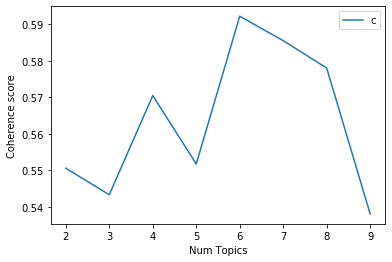

In [28]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of",cv)

Num Topics = 2  has Coherence Value of 0.550567039120617
Num Topics = 3  has Coherence Value of 0.5432918490922285
Num Topics = 4  has Coherence Value of 0.5704826613802708
Num Topics = 5  has Coherence Value of 0.5517344460209271
Num Topics = 6  has Coherence Value of 0.592212848254514
Num Topics = 7  has Coherence Value of 0.5855350361910032
Num Topics = 8  has Coherence Value of 0.5780169905477551
Num Topics = 9  has Coherence Value of 0.538043360805815


In [30]:



import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/Users/kartik.sonaghela/Documents/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:/Users/kartik.sonaghela/Documents/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

In [31]:
#mallet_path = r'C:\Users\kartik.sonaghela\Documents\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=7, id2word=dictionary)

In [32]:
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('headphone', 0.11520522388059702), ('price', 0.07334421641791045), ('great', 0.06529850746268656), ('bluetooth', 0.05363805970149254), ('mic', 0.03801305970149254), ('call', 0.025652985074626867), ('voice', 0.02320429104477612), ('thing', 0.021455223880597014), ('phone', 0.021338619402985076), ('review', 0.02028917910447761)]), (1, [('ear', 0.10836128136926101), ('time', 0.052850699664623565), ('comfortable', 0.04082340696195212), ('tight', 0.040360818781080145), ('headset', 0.03804787787672025), ('hour', 0.03770093674106627), ('pain', 0.03654446628888632), ('long', 0.03307505493234648), ('head', 0.03110905516364057), ('problem', 0.028333526078408697)]), (2, [('awesome', 0.12893194593948093), ('boat', 0.07295778016983615), ('bass', 0.07188135390503528), ('headphone', 0.0668580313359646), ('amazing', 0.06063867958378184), ('superb', 0.03994737471594307), ('love', 0.03588087549336204), ('cable', 0.028824303313000836), ('perfect', 0.021050113622772395), ('happy', 0.0210501136227723

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, reviews_2, 20, 3,1)

3
0.5589861303245939
4
0.5470055000581637
5
0.5208860155014718
6
0.5511160772476479
7
0.5229724761391747
8
0.5167978988745837
9
0.5406912596844644
10
0.4944806339769435
11
0.49966420207271206
12
0.4954096159414663
13
0.48305133233714226
14
0.4814221168837239
15
0.4834911806864774
16
0.4721606482726721
17
0.4689421076447423
18
0.46484676210455234
19
0.46160286102697584


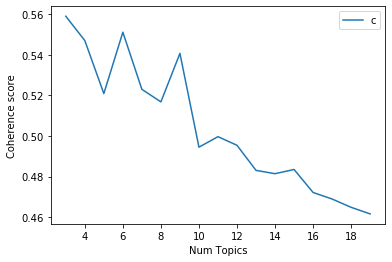

In [35]:
# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of",cv)

Num Topics = 3  has Coherence Value of 0.5589861303245939
Num Topics = 4  has Coherence Value of 0.5470055000581637
Num Topics = 5  has Coherence Value of 0.5208860155014718
Num Topics = 6  has Coherence Value of 0.5511160772476479
Num Topics = 7  has Coherence Value of 0.5229724761391747
Num Topics = 8  has Coherence Value of 0.5167978988745837
Num Topics = 9  has Coherence Value of 0.5406912596844644
Num Topics = 10  has Coherence Value of 0.4944806339769435
Num Topics = 11  has Coherence Value of 0.49966420207271206
Num Topics = 12  has Coherence Value of 0.4954096159414663
Num Topics = 13  has Coherence Value of 0.48305133233714226
Num Topics = 14  has Coherence Value of 0.4814221168837239
Num Topics = 15  has Coherence Value of 0.4834911806864774
Num Topics = 16  has Coherence Value of 0.4721606482726721
Num Topics = 17  has Coherence Value of 0.4689421076447423
Num Topics = 18  has Coherence Value of 0.46484676210455234
Num Topics = 19  has Coherence Value of 0.46160286102697584


In [37]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \\
of {coherence_values[best_result_index]}''')

The 3 topics gives the highest coherence score \
of 0.5589861303245939


In [38]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LDA(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

In [39]:
#Creating Topic Distance Visualization 

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.403095  0.034582       1        1  34.527733
1      0.164376 -0.298551       2        1  33.592476
2      0.238719  0.263969       3        1  31.879791, topic_info=          Term         Freq        Total Category  logprob  loglift
9      product  3377.000000  3377.000000  Default  30.0000  30.0000
10     quality  2838.000000  2838.000000  Default  29.0000  29.0000
8         good  6021.000000  6021.000000  Default  28.0000  28.0000
11       sound  2775.000000  2775.000000  Default  27.0000  27.0000
15        bass  1957.000000  1957.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
103   bassread    59.095963    59.095963   Topic3  -5.8480   1.1432
232  satisfied   119.286297   122.493341   Topic3  -5.1456   1.1167
8         good  3250.277982  6021.164557   Topic3  -1.8407   0.5267
63   excellent   196.986553   450.343078   Topic3  -4.6440   0.3163
11       sound   124.758149  2775.915156   Topic3  -5.1008  -1.9592

[189 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
13        2  0.935441   adjuster
91        2  0.003605    amazing
91        3  0.996765    amazing
14        2  1.052371     approx
79        1  0.998652    average
...     ...       ...        ...
184       2  1.004733  wonderful
325       1  1.002273       work
185       3  1.001090      worth
459       3  1.021270    writing
425       3  1.002771       year

[169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [51]:
def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=reviews_2):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
    
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                
                topic_keywords = ", ".join([word for word, prop in wp])
                
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=reviews_2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.6424,"good, quality, sound, bass, product, battery, awesome, backup, headphone, design","[nice, produt, design, lot, easy, carry, stylish]"
1,1,4.0,0.9046,"good, quality, sound, bass, product, battery, awesome, backup, headphone, design","[awesome, sound, sound, quality, good, wish, product, product]"
2,2,4.0,0.6962,"good, quality, sound, bass, product, battery, awesome, backup, headphone, design","[awesome, sound, quality, pro, battery, life, min, approx, call, time, awesome, sound, output, bass, treble, clear, equaliser, equaliser, sound, wary, handset, sound, quality, weightless, carry, h..."
3,3,1.0,0.4289,"product, nice, good, productread, awesome, qualityread, excellent, love, superread, satisfied","[good, product, quality, good, product, january, pandamic, situation, useful, helpful, overall, bass, sound, quality, good, thing, sigh, relief, provide, wire, help, case, charge, more]"
4,4,4.0,0.4998,"good, quality, sound, bass, product, battery, awesome, backup, headphone, design","[awesome, bass, sound, quality, good, bettary, long, life, purchase, grateful, product]"


In [52]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9340,"headphone, good, boat, bluetooth, more, bad, price, headset, day, range","[awesome, first, thank, fast, delivery, withon, day, specification, good, well, credit, dear]"
1,1.0,0.8775,"product, nice, good, productread, awesome, qualityread, excellent, love, superread, satisfied","[nice, product, vishay, hard, ahe, bahi]"
2,2.0,0.9387,"ear, good, pain, tight, more, long, comfortable, use, time, hour","[indicator, comfortable, long, time, useafter, min, ear, little, bit, painbcoz, tight, fighting, more]"
3,3.0,0.9047,"battery, great, product, amazing, backup, month, cable, worth, purchase, use","[kollila, peten, complaint, ayi, month, polum, ayillawarranty, okke]"
4,4.0,0.9591,"good, quality, sound, bass, product, battery, awesome, backup, headphone, design","[good, product, price, range, battery, backup, good, careful, choosing, colour, different, different, colour, leather, finish, fabric, zoom, image, leather, finish]"
5,5.0,0.9522,"good, sound, bass, quality, music, mic, call, headphone, clear, voice","[poor, sound, quality, much, sound, good, comfort, hrs, use, good, calling, headphone, well, experience, budget, bullet, bass]"
6,6.0,0.8282,"more, buy, don, amazing, fantastic, wonderful, fabulous, reasonable, price, excellentread","[fragile, break, top, monthsread]"
